In [ ]:
# ============================================
# Notebook 1 — LIMPIEZA 2024 (SIMA)
# ============================================
import pandas as pd
import numpy as np
import re
from pathlib import Path

pd.set_option("display.max_columns", 200)

# ----------------- Rutas -----------------
FILE_2024   = "DATOS HISTÓRICOS 2024_TODAS ESTACIONES.xlsx"
FILE_LABELS = "Etiquetas.xlsx"

# ----------------- Salidas -----------------
OUT_UNIFICADO          = "sima_2024_unificado.csv"
OUT_LIMPIO             = "sima_2024_limpio.csv"
OUT_REP_CALIDAD        = "sima_2024_reporte_calidad.csv"
OUT_FINAL              = "sima_2024_final.csv"
OUT_REP_IMPUT          = "sima_2024_reporte_imputacion.csv"
OUT_OUTLIERS_LOG_PM25  = "sima_2024_outliers_log_pm25.csv"
OUT_FINAL_SIN_OUTLIERS = "sima_2024_final_sin_outliers.csv"

YEAR = 2024

# ----------------- Rangos 2024 (foto) -----------------
RANGOS_2024 = {
    "pm10":  (0, 999),
    "pm2_5": (0, 999),
    "o3":    (0, 180),
    "no":    (0, 400),
    "no2":   (0, 130),
    "nox":   (0, 300),
    "so2":   (0, 150),
    "co":    (0, 18),
    "rh":    (0, 100),
    "wsr":   (0, 38),
    "tout":  (-4, 45.5),
    "sr":    (0, 1.26),
    "prs":   (687.5, 740),
    "wdr":   (0, 360),
    "rainf": (0, 50),
}

# ----------------- Política de imputación -----------------
IMPUTACION = {
    "pm10":  "interp",
    "pm2_5": "interp",
    "o3":    "interp",
    "no":    "interp",
    "no2":   "interp",
    "nox":   "interp",
    "so2":   "interp",
    "co":    "interp",
    "tout":  "interp",
    "rh":    "interp",
    "wsr":   "interp",
    "wdr":   None,                   # circular -> no imputar
    "sr":    "median_month_station", # meteo estable
    "prs":   "median_month_station",
    "rainf": None,                   # eventos discretos
}
GROUP_KEYS_MEDIAN = ["estacion", "year", "month"]


# ============================================
# Utilidades
# ============================================
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (df.columns.astype(str)
                  .str.strip().str.lower()
                  .str.replace(" ", "_")
                  .str.replace(r"[^\w]+", "_", regex=True))
    return df

def try_read_etiquetas(path: str):
    """
    Lee Etiquetas.xlsx si existe; regresa diccionario opcional de abreviaturas→descripción/unidad.
    No es estrictamente necesario para el pipeline, pero ayuda a documentar.
    """
    try:
        xl = pd.ExcelFile(path)
        # Tomamos la primera hoja que contenga "Tabla 3" o columnas típicas
        sheet = xl.sheet_names[0]
        et = pd.read_excel(xl, sheet_name=sheet, header=None)
        return et
    except Exception:
        return None

def build_regex_mapping(columns):
    """
    Construye un mapeo robusto nombre_origen -> nombre_canon para el 2024,
    usando patrones típicos de columnas con unidades.
    """
    mapping = {}
    for c in columns:
        c0 = c
        # normalizar símbolos raros (º, etc.)
        c = c.replace("º", "")
        # pares comunes (2024)
        pairs = [
            (r"^co__?pp?m_?$",         "co"),
            (r"^no__?ppb_?$",          "no"),
            (r"^no2__?ppb_?$",         "no2"),
            (r"^nox__?ppb_?$",         "nox"),
            (r"^o3__?ppb_?$",          "o3"),
            (r"^pm10__?ug_m3_?$",      "pm10"),
            (r"^pm2_?5__?ug_m3_?$",    "pm2_5"),
            (r"^prs__?mmhg_?$",        "prs"),
            (r"^rainf__?mm_?h_?$",     "rainf"),
            (r"^rh__?$",               "rh"),
            (r"^so2__?ppb_?$",         "so2"),
            (r"^sr__?kw_?m2_?$",       "sr"),
            (r"^tout__?c_?$",          "tout"),
            (r"^wsr__?km_?h_?$",       "wsr"),
            (r"^wdr__?azimutal_?$",    "wdr"),
            # alternativas por si viniera sin sufijo:
            (r"^co$", "co"), (r"^no$", "no"), (r"^no2$", "no2"), (r"^nox$", "nox"),
            (r"^o3$", "o3"), (r"^pm10$", "pm10"), (r"^pm2_5$", "pm2_5"),
            (r"^prs$", "prs"), (r"^rainf$", "rainf"), (r"^rh$", "rh"),
            (r"^so2$", "so2"), (r"^sr$", "sr"), (r"^tout$", "tout"),
            (r"^wsr$", "wsr"), (r"^wdr$", "wdr"),
        ]
        for pat, target in pairs:
            if re.match(pat, c):
                mapping[c0] = target
                break
    return mapping

def aplicar_rangos(df: pd.DataFrame, rangos: dict) -> pd.DataFrame:
    df = df.copy()
    for col, (lo, hi) in rangos.items():
        if col in df.columns:
            oor = (df[col].notna()) & ((df[col] < lo) | (df[col] > hi))
            df[f"{col}__oor"] = oor
            df.loc[oor, col] = np.nan
    if "wdr" in df.columns:
        df.loc[df["wdr"] > 360, "wdr"] = 360
        df.loc[df["wdr"] < 0, "wdr"] = np.nan
    return df

def impute_interp_per_station(frame, cols):
    frame = frame.copy().sort_values("date")
    for c in cols:
        if c in frame.columns:
            frame[c] = frame[c].interpolate(method="linear", limit_direction="both")
    return frame

def impute_median_month_station(df, col):
    med = df.groupby(GROUP_KEYS_MEDIAN, dropna=False)[col].transform("median")
    return df[col].fillna(med)

def detect_anomalies(sta_df, var, win=7, z_thresh=3.0, mad_k=3.5, jump_abs=60):
    g = sta_df.copy().sort_values("date_d")
    s = g[var].astype(float)

    mu  = s.rolling(win, min_periods=3, center=True).mean()
    sd  = s.rolling(win, min_periods=3, center=True).std(ddof=0)
    z   = (s - mu) / sd

    med = s.rolling(win, min_periods=3, center=True).median()
    mad = (s - med).abs().rolling(win, min_periods=3, center=True).median()
    z_mad = 0.6745 * (s - med) / (mad.replace(0, np.nan))

    jump = s.diff().abs()
    std3 = s.rolling(3, min_periods=2, center=True).std()
    flat = std3.fillna(0) < 0.01

    g["anomaly"]  = (z.abs() > z_thresh) | (z_mad.abs() > mad_k) | (jump > jump_abs) | flat
    g["z_score"]  = z
    g["z_mad"]    = z_mad
    g["jump_abs"] = jump
    g["flat"]     = flat
    return g


# ============================================
# 0) (Opcional) Leer Etiquetas.xlsx
# ============================================
et = try_read_etiquetas(FILE_LABELS)
if et is not None:
    print("Etiquetas.xlsx cargado (para referencia).")
else:
    print("No se pudo leer Etiquetas.xlsx (continuamos igual).")


# ============================================
# 1) Carga, unificación y normalización de columnas
# ============================================
xls = pd.ExcelFile(FILE_2024)
sheets = [s for s in xls.sheet_names if s.strip().upper() not in {"CATÁLOGO", "CATALOGO"}]

frames = []
for s in sheets:
    df_s = pd.read_excel(xls, sheet_name=s)
    df_s["__sheet"] = s
    frames.append(df_s)

df_all = pd.concat(frames, ignore_index=True, sort=False)
df_all = standardize_columns(df_all)

# detectar columna temporal
cands = [c for c in df_all.columns if any(k in c for k in ["fecha","hora","time","date","datetime"])]
dt_col = None
for c in cands:
    try:
        test = pd.to_datetime(df_all[c], errors="coerce")
        if test.notna().mean() > 0.4:
            dt_col = c
            break
    except:
        pass
if dt_col is None:
    raise RuntimeError("No se detectó columna de fecha/hora.")

df_all["date"] = pd.to_datetime(df_all[dt_col], errors="coerce")
df_all.rename(columns={"__sheet": "estacion"}, inplace=True)
df_all["year"]  = df_all["date"].dt.year
df_all["month"] = df_all["date"].dt.month
df_all["day"]   = df_all["date"].dt.day
df_all["hour"]  = df_all["date"].dt.hour

# filtrar 2024
df = df_all[df_all["year"] == YEAR].copy()

# ---------- Normalizar nombres con unidades ----------
name_map = build_regex_mapping(df.columns)
df = df.rename(columns=name_map)

# quitar duplicados por (estacion, date)
before_dups = len(df)
df = df.drop_duplicates(subset=["estacion", "date"])
after_dups = len(df)

df.to_csv(OUT_UNIFICADO, index=False)
print(f"Unificación 2024 OK — hojas: {sheets}")
print("Filas before/after dups:", before_dups, after_dups)
print("Columnas tras normalizar:", sorted([c for c in df.columns if c in RANGOS_2024.keys()]))


# ============================================
# 2) Validación de rangos 2024
# ============================================
df_lim = aplicar_rangos(df, RANGOS_2024)
df_lim.to_csv(OUT_LIMPIO, index=False)

rows = []
for col, (lo, hi) in RANGOS_2024.items():
    if col in df_lim.columns:
        fuera = int(df_lim.get(f"{col}__oor", pd.Series(False, index=df_lim.index)).sum())
        rows.append({
            "variable": col,
            "fuera_rango": fuera,
            "%_fuera_rango": round(100*fuera/len(df_lim), 3),
            "%_nulos_post": round(100*df_lim[col].isna().mean(), 3),
            "min_obs": df_lim[col].min(skipna=True),
            "p50_obs": df_lim[col].median(skipna=True),
            "p95_obs": df_lim[col].quantile(0.95),
            "max_obs": df_lim[col].max(skipna=True),
            "rango_2024": (lo, hi),
        })
rep_cal = pd.DataFrame(rows)
if rep_cal.empty:
    print("⚠️ No se pudo generar reporte de rangos (verifica el mapeo de columnas).")
else:
    rep_cal = rep_cal.sort_values("%_fuera_rango", ascending=False)
    rep_cal.to_csv(OUT_REP_CALIDAD, index=False)
    print("\nValidación de rangos 2024 — top variables fuera de rango:")
    display(rep_cal.head(10))


# ============================================
# 3) Imputación (interp + mediana por mes-estación)
# ============================================
df_lim = df_lim.sort_values(["estacion","date"]).reset_index(drop=True)

# Asegurar year/month
for col, attr in [("year","year"), ("month","month")]:
    if col not in df_lim.columns:
        df_lim[col] = getattr(df_lim["date"].dt, attr)

cols_interp = [c for c, m in IMPUTACION.items() if m == "interp" and c in df_lim.columns]
cols_med    = [c for c, m in IMPUTACION.items() if m == "median_month_station" and c in df_lim.columns]

nan_before = {c: int(df_lim[c].isna().sum()) for c in IMPUTACION if c in df_lim.columns}

# Interpolación por estación
if cols_interp:
    df_imp = (df_lim.groupby("estacion", group_keys=False)
                    .apply(lambda g: impute_interp_per_station(g, cols_interp)))
else:
    df_imp = df_lim.copy()

# Median por mes-estación
for c in cols_med:
    df_imp[c] = impute_median_month_station(df_imp, c)

nan_after = {c: int(df_imp[c].isna().sum()) for c in IMPUTACION if c in df_imp.columns}

# Clip final de seguridad
for col, (lo, hi) in RANGOS_2024.items():
    if col in df_imp.columns:
        df_imp[col] = df_imp[col].clip(lower=lo, upper=hi)

# Quitar flags y guardar
flag_cols = [c for c in df_imp.columns if c.endswith("__oor")]
df_final = df_imp.drop(columns=flag_cols).copy()
df_final.to_csv(OUT_FINAL, index=False)

rep_imp = (pd.DataFrame({
    "variable": [c for c in IMPUTACION if c in df_imp.columns],
    "metodo":   [IMPUTACION[c] if IMPUTACION[c] else "none" for c in IMPUTACION if c in df_imp.columns],
    "n_nulos_antes": [nan_before.get(c, np.nan) for c in IMPUTACION if c in df_imp.columns],
    "n_nulos_despues": [nan_after.get(c, np.nan) for c in IMPUTACION if c in df_imp.columns],
})
.assign(delta_imputados=lambda d: d["n_nulos_antes"] - d["n_nulos_despues"])
.sort_values("variable"))
rep_imp.to_csv(OUT_REP_IMPUT, index=False)

print("\nImputación 2024 — resumen:")
display(rep_imp.head(12))


# ============================================
# 4) Outliers diarios PM2.5 + bajar al nivel horario
# ============================================
VAR = "pm2_5"
if VAR in df_final.columns:
    df_final["date_d"] = df_final["date"].dt.normalize()
    df_daily = (df_final.groupby(["estacion","date_d"], as_index=False)[VAR]
                        .mean()
                        .drop_duplicates(subset=["estacion","date_d"])
                        .sort_values(["estacion","date_d"]))

    df_flagged = pd.concat(
        [detect_anomalies(g, VAR) for _, g in df_daily.groupby("estacion")],
        ignore_index=True
    )

    anom = (df_flagged[df_flagged["anomaly"]]
            .sort_values(["estacion","date_d"])
            .rename(columns={"date_d":"date"}))
    anom["variable"] = VAR
    anom[["estacion","date",VAR,"z_score","z_mad","jump_abs","flat","variable"]].to_csv(OUT_OUTLIERS_LOG_PM25, index=False)
    print(f"Outliers PM2.5 diarios: {len(anom)} -> {OUT_OUTLIERS_LOG_PM25}")

    keys = set(zip(anom["estacion"], pd.to_datetime(anom["date"]).dt.normalize()))
    mask = df_final.apply(lambda r: (r["estacion"], r["date_d"]) in keys, axis=1)
    n_afect = int(mask.sum())
    df_final.loc[mask, VAR] = np.nan
    df_final = df_final.drop(columns=["date_d"]).sort_values(["estacion","date"])
else:
    print("⚠️ No existe columna pm2_5; se omite detección de outliers diarios.")

df_final.to_csv(OUT_FINAL_SIN_OUTLIERS, index=False)

print("\nArchivos generados:")
for p in [OUT_UNIFICADO, OUT_LIMPIO, OUT_REP_CALIDAD, OUT_FINAL, OUT_REP_IMPUT, OUT_OUTLIERS_LOG_PM25, OUT_FINAL_SIN_OUTLIERS]:
    print(" -", Path(p).resolve())


Etiquetas.xlsx cargado (para referencia).
Unificación 2024 OK — hojas: ['SE', 'CE', 'SO', 'NE2', 'SE2', 'SE3', 'NE', 'NO', 'NO2', 'NTE', 'NTE2', 'SO2', 'SUR', 'NO3', 'NE3']
Filas before/after dups: 131741 131741
Columnas tras normalizar: ['co', 'no', 'no2', 'nox', 'o3', 'pm10', 'pm2_5', 'prs', 'rainf', 'rh', 'so2', 'sr', 'tout', 'wdr', 'wsr']

Validación de rangos 2024 — top variables fuera de rango:


,variable,fuera_rango,%_fuera_rango,%_nulos_post,min_obs,p50_obs,p95_obs,max_obs,rango_2024
12,prs,405,0.307,3.336,687.50,714.100,731.000,740.000,"(687.5, 740)"
11,sr,151,0.115,5.619,0.00,0.003,0.624,1.252,"(0, 1.26)"
5,nox,44,0.033,4.782,0.50,18.300,76.600,299.600,"(0, 300)"
10,tout,40,0.030,8.382,-3.91,24.310,33.810,45.100,"(-4, 45.5)"
8,rh,25,0.019,11.005,0.00,60.000,88.000,100.000,"(0, 100)"
9,wsr,24,0.018,2.299,0.10,7.400,16.000,38.000,"(0, 38)"
3,no,2,0.002,5.478,0.50,5.400,45.200,371.800,"(0, 400)"
2,o3,2,0.002,4.848,1.00,24.000,66.000,176.000,"(0, 180)"
7,co,2,0.002,8.720,0.00,1.210,3.260,15.300,"(0, 18)"
14,rainf,2,0.002,1.887,0.00,0.000,0.000,45.000,"(0, 50)"


/tmp/ipython-input-3629814441.py:291: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: impute_interp_per_station(g, cols_interp)))



Imputación 2024 — resumen:


,variable,metodo,n_nulos_antes,n_nulos_despues,delta_imputados
7,co,interp,11488,0,11488
3,no,interp,7217,0,7217
4,no2,interp,6706,0,6706
5,nox,interp,6300,0,6300
2,o3,interp,6387,0,6387
0,pm10,interp,4953,0,4953
1,pm2_5,interp,40847,8782,32065
13,prs,median_month_station,4395,0,4395
14,rainf,none,2486,2486,0
9,rh,interp,14498,0,14498


Outliers PM2.5 diarios: 792 -> sima_2024_outliers_log_pm25.csv

Archivos generados:
 - /content/sima_2024_unificado.csv
 - /content/sima_2024_limpio.csv
 - /content/sima_2024_reporte_calidad.csv
 - /content/sima_2024_final.csv
 - /content/sima_2024_reporte_imputacion.csv
 - /content/sima_2024_outliers_log_pm25.csv
 - /content/sima_2024_final_sin_outliers.csv


In [ ]:
import pandas as pd

# Cargamos el dataset ya depurado hasta antes de la EDA
df = pd.read_csv("sima_2024_final_sin_outliers.csv", parse_dates=["date"])

# --- Paso 1: interpolación por estación ---
def impute_pm25_interp(g):
    g = g.sort_values("date")
    g["pm2_5"] = g["pm2_5"].interpolate(method="linear", limit_direction="both")
    return g

df = df.groupby("estacion", group_keys=False).apply(impute_pm25_interp)

# --- Paso 2: mediana mensual por estación ---
df["month"] = df["date"].dt.month
median_month = (
    df.groupby(["estacion", "month"])["pm2_5"]
      .transform(lambda x: x.fillna(x.median()))
)
df["pm2_5"] = df["pm2_5"].fillna(median_month)

# --- Chequeo final ---
faltantes = df["pm2_5"].isna().sum()
print(f"NaN restantes en pm2_5: {faltantes}")

# Validación de rangos (2024: 0–450)
outside = ((df["pm2_5"] < 0) | (df["pm2_5"] > 450)).sum()
print(f"Fuera de rango pm2_5 post-imputación: {outside}")

# Guardar dataset final listo para la EDA
df.to_csv("sima_2024_final_imputado.csv", index=False)
print(" Archivo generado: sima_2024_final_imputado.csv")


/tmp/ipython-input-4283379696.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("estacion", group_keys=False).apply(impute_pm25_interp)


NaN restantes en pm2_5: 8782
Fuera de rango pm2_5 post-imputación: 0
✅ Archivo generado: sima_2024_final_imputado.csv


In [ ]:
import pandas as pd

# Cargar dataset imputado previo
df = pd.read_csv("sima_2024_final_imputado.csv", parse_dates=["date"])

# --- 1) Interpolación lineal por estación ---
def interp_pm25(g):
    g = g.sort_values("date")
    g["pm2_5"] = g["pm2_5"].interpolate(method="linear", limit_direction="both")
    return g

df = df.groupby("estacion", group_keys=False).apply(interp_pm25)

# --- 2) Mediana mensual por estación (para los huecos largos) ---
df["month"] = df["date"].dt.month
df["pm2_5"] = df.groupby(["estacion", "month"])["pm2_5"].transform(
    lambda x: x.fillna(x.median())
)

# --- 3) Chequeo final ---
faltantes = df["pm2_5"].isna().sum()
print(f"NaN restantes en pm2_5: {faltantes}")

# Validación de rango oficial 2024 (0–450)
out_pm25 = ((df["pm2_5"] < 0) | (df["pm2_5"] > 450)).sum()
print(f"Valores fuera de rango en pm2_5: {out_pm25}")

# --- 4) Guardar archivo limpio ---
df.to_csv("sima_2024_final_imputado_v2.csv", index=False)
print(" Archivo final guardado: sima_2024_final_imputado_v2.csv")


/tmp/ipython-input-3676018245.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("estacion", group_keys=False).apply(interp_pm25)


NaN restantes en pm2_5: 8782
Valores fuera de rango en pm2_5: 0
✅ Archivo final guardado: sima_2024_final_imputado_v2.csv



Cobertura mensual por estación - ORIGINAL
estacion   CE   NE  NE2  NE3   NO  NO2  NO3  NTE  NTE2   SE  SE2  SE3   SO  \
date                                                                         
1         744  744  744  744  744  744  744  744   744  744  744  744  744   
2         696  696  696  696  696  696  696  696   696  696  696  696  696   
3         744  744  744  744  744  744  744  744   744  744  744  744  744   
4         720  720  718  718  720  718  720  718   718  720  718  718  720   
5         744  744  744  744  744  744  744  744   744  744  744  744  744   
6         720  720  720  720  720  720  720  720   720  720  720  720  720   
7         744  744  744  744  744  744  744  744   744  744  744  744  744   
8         744  744  744  744  744  744  744  744   744  744  744  744  744   
9         720  720  720  720  720  720  720  720   720  720  720  720  720   
10        744  744  744  744  743  744  744  744   744  744  744  744  744   
11        720  720  7

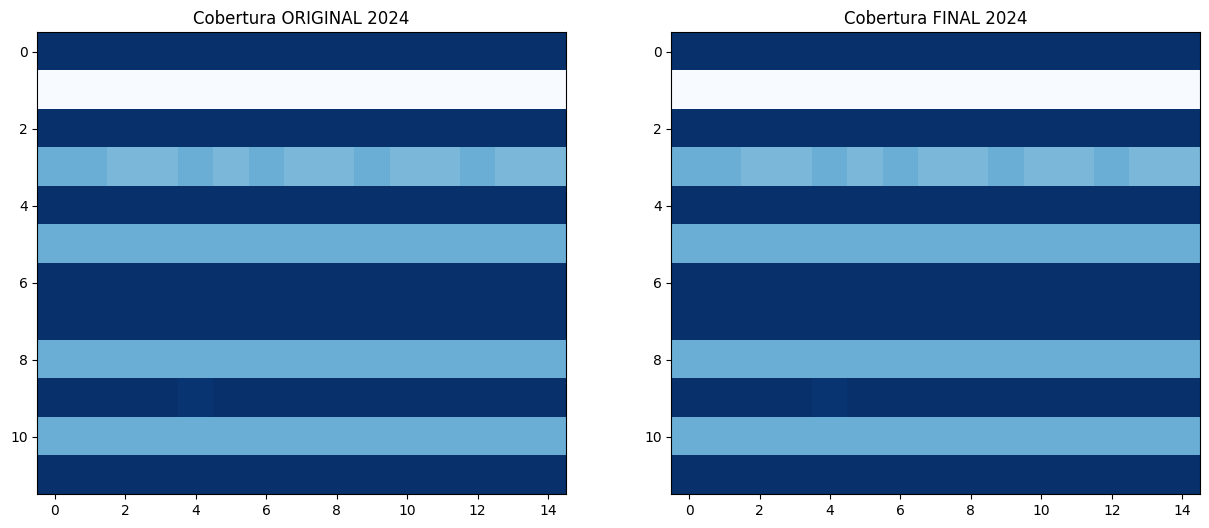

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datasets
orig = pd.read_csv("sima_2024_unificado.csv", parse_dates=["date"])
final = pd.read_csv("sima_2024_final.csv", parse_dates=["date"])

# Función de conteo por mes y estación
def coverage_table(df, name):
    cov = df.groupby([df["date"].dt.month, "estacion"]).size().unstack(fill_value=0)
    print(f"\nCobertura mensual por estación - {name}")
    print(cov)
    return cov

# Revisar ambos
cov_orig = coverage_table(orig, "ORIGINAL")
cov_final = coverage_table(final, "FINAL")

# Graficar heatmaps
fig, axes = plt.subplots(1, 2, figsize=(15,6))
axes[0].imshow(cov_orig, aspect="auto", cmap="Blues")
axes[0].set_title("Cobertura ORIGINAL 2024")
axes[1].imshow(cov_final, aspect="auto", cmap="Blues")
axes[1].set_title("Cobertura FINAL 2024")
plt.show()


In [ ]:
import pandas as pd

# Carga tu dataset
df = pd.read_csv("sima_2024_final_imputado_v2.csv", parse_dates=["fecha_y_hora"])

# Nos quedamos con la fecha bien separada
df["year"] = df["fecha_y_hora"].dt.year
df["month"] = df["fecha_y_hora"].dt.month

# Variables contaminantes principales
vars_check = ["pm2_5","pm10","o3","no2","so2","co"]

# % de nulos por estación y mes
faltantes = (
    df.groupby(["estacion","year","month"])[vars_check]
      .apply(lambda g: g.isna().mean()*100)
      .reset_index()
)

print(faltantes.head(20))


   estacion  year  month  pm2_5  pm10   o3  no2  so2   co
0        CE  2024      1    0.0   0.0  0.0  0.0  0.0  0.0
1        CE  2024      2    0.0   0.0  0.0  0.0  0.0  0.0
2        CE  2024      3    0.0   0.0  0.0  0.0  0.0  0.0
3        CE  2024      4    0.0   0.0  0.0  0.0  0.0  0.0
4        CE  2024      5    0.0   0.0  0.0  0.0  0.0  0.0
5        CE  2024      6    0.0   0.0  0.0  0.0  0.0  0.0
6        CE  2024      7    0.0   0.0  0.0  0.0  0.0  0.0
7        CE  2024      8    0.0   0.0  0.0  0.0  0.0  0.0
8        CE  2024      9    0.0   0.0  0.0  0.0  0.0  0.0
9        CE  2024     10    0.0   0.0  0.0  0.0  0.0  0.0
10       CE  2024     11    0.0   0.0  0.0  0.0  0.0  0.0
11       CE  2024     12    0.0   0.0  0.0  0.0  0.0  0.0
12       NE  2024      1    0.0   0.0  0.0  0.0  0.0  0.0
13       NE  2024      2    0.0   0.0  0.0  0.0  0.0  0.0
14       NE  2024      3    0.0   0.0  0.0  0.0  0.0  0.0
15       NE  2024      4    0.0   0.0  0.0  0.0  0.0  0.0
16       NE  2

In [ ]:
# Detectar meses con más del 50% de datos faltantes en al menos una variable
huecos = faltantes.melt(id_vars=["estacion","year","month"],
                        var_name="variable", value_name="%_faltante")
huecos_grandes = huecos[huecos["%_faltante"] > 50]

print(huecos_grandes.sort_values(["%_faltante"], ascending=False))


   estacion  year  month variable  %_faltante
36      NE3  2024      1    pm2_5       100.0
37      NE3  2024      2    pm2_5       100.0
38      NE3  2024      3    pm2_5       100.0
39      NE3  2024      4    pm2_5       100.0
40      NE3  2024      5    pm2_5       100.0
41      NE3  2024      6    pm2_5       100.0
42      NE3  2024      7    pm2_5       100.0
43      NE3  2024      8    pm2_5       100.0
44      NE3  2024      9    pm2_5       100.0
45      NE3  2024     10    pm2_5       100.0
46      NE3  2024     11    pm2_5       100.0
47      NE3  2024     12    pm2_5       100.0
